## Background

In this notebook, I'll walk through a modified algorithm (suggested by Claude) to calculate the average stroke width of letters in a text image.

This algorithm is part of my exploration of non-ML baselines to classify text images into various typeface categories (e.g., “humanist sans,” “grotesque sans,” “script,” “display,” etc.). Once the non-ML baseline is established, I’ll train a neural network for this task. This is one of many notebooks in my [**TypefaceClassifier** project series](https://vishalbakshi.github.io/blog/#category=TypefaceClassifier).

In [1]:
#| code-fold: true
#| code-summary: "Show imports"

import cv2
import numpy as np, pandas as pd, matplotlib.pyplot as plt

## Load the Image and Binarize it

As is the case with all of the algorithm so far ([aspect ratio](https://vishalbakshi.github.io/blog/posts/2024-08-14-typefaceclassifier-aspect-ratio/), [lowercase-to-uppercase ratio](https://vishalbakshi.github.io/blog/posts/2024-08-12-typefaceclassifier-x-to-cap-height/)) we start by binarizing the image:

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
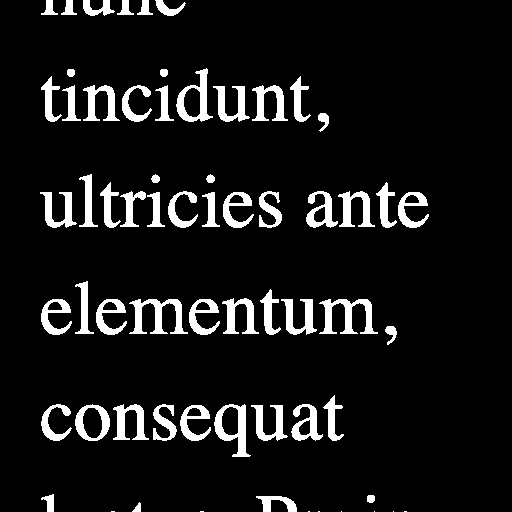

In [2]:
path = 'serif-76px.png'
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
_, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
binary

## Create a Skeleton

Using OpenCV's `ximgproc.thinning` algorithm, the binary image is converted to a "skeleton"---this approximates the "centerline" of the stroke.

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
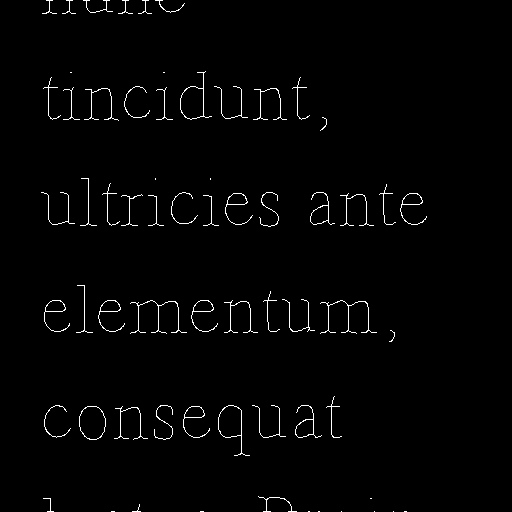

In [3]:
skeleton = cv2.ximgproc.thinning(binary)
skeleton

## Calculate Distance from White-to-Black Pixels

`distanceTransform` uses the Euclidean Distance (`cv2.DIST_L2`) to calculate the distance between each white pixel to the closes black pixel in the `binary`.

In [4]:
dist_transform = cv2.distanceTransform(binary, cv2.DIST_L2, 5)
dist_transform

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

For each `skeleton` white pixel, we can find the corresponding distance between that pixel and the closest black pixel, and multiply it by 2 to get the full stroke "width":

In [5]:
# Initialize stroke width map
stroke_width_map = np.zeros_like(dist_transform)

# Find non-zero pixels in the skeleton
y, x = np.where(skeleton > 0)

# For each skeleton pixel, find the corresponding stroke width
for i, j in zip(y, x):
    stroke_width = dist_transform[i, j] * 2  # Diameter is twice the radius
    stroke_width_map[i, j] = stroke_width

Visualizing `stroke_width_map`:

In [6]:
# Prepare for visualization
def normalize_and_colorize(img):
    normalized = cv2.normalize(img, None, 0, 1, cv2.NORM_MINMAX)
    return cv2.applyColorMap((normalized * 255).astype(np.uint8), cv2.COLORMAP_JET)

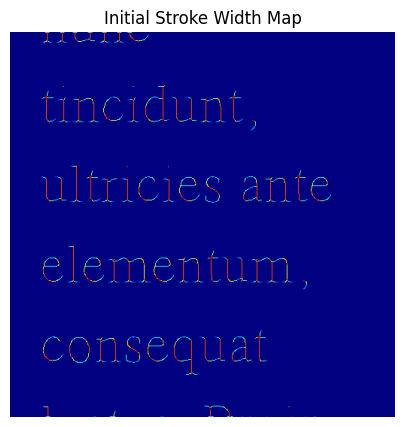

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

initial_color = normalize_and_colorize(stroke_width_map)
ax.imshow(cv2.cvtColor(initial_color, cv2.COLOR_BGR2RGB));
ax.set_title('Initial Stroke Width Map');
ax.axis('off');

## Dilate the Skeleton

We then `dilate` the `stroke_width_map` to fill out the strokes:

In [8]:
kernel = np.ones((3, 3), np.uint8)
stroke_width_map_dilated = cv2.dilate(stroke_width_map, kernel, iterations=2)

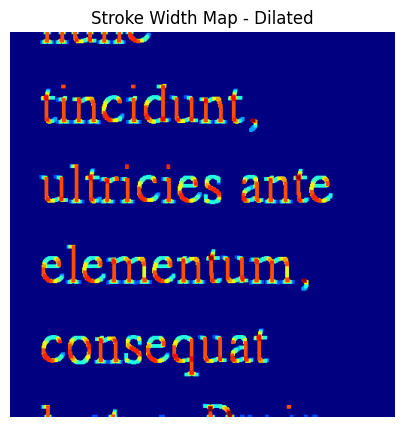

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

dilated = normalize_and_colorize(stroke_width_map_dilated)
ax.imshow(cv2.cvtColor(dilated, cv2.COLOR_BGR2RGB));
ax.set_title('Stroke Width Map - Dilated');
ax.axis('off');

## Final Stroke Width Map

The `dilate`d stroke width map is a result of applyig a 3x3 pixel kernel to the `skeleton` so it doesn't have the exact shape of the original image. To get a better approximation of the original, we mask the stroke width map with the `binary` image:

In [10]:
# Mask the stroke width map with the binary image
stroke_width_map_final = stroke_width_map_dilated * (binary > 0)

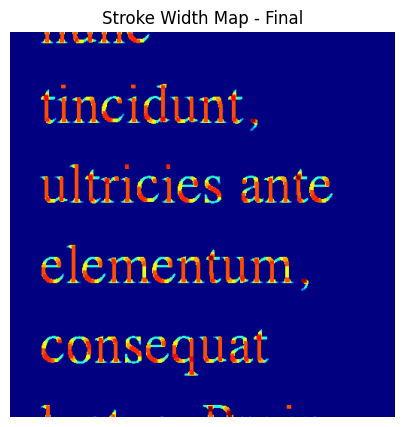

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

final = normalize_and_colorize(stroke_width_map_final)
ax.imshow(cv2.cvtColor(final, cv2.COLOR_BGR2RGB));
ax.set_title('Stroke Width Map - Final');
ax.axis('off');

I'll wrap the above code into a `stroke_width_viz` function and apply it to different images.

In [12]:
#| code-fold: true
#| code-summary: "Show `stroke_width_viz` code"

def stroke_width_viz(path):
    # Read the image
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # Threshold the image
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Create a skeleton of the image
    skeleton = cv2.ximgproc.thinning(binary)

    # Compute distance transform
    dist_transform = cv2.distanceTransform(binary, cv2.DIST_L2, 5)

    # Initialize stroke width map
    stroke_width_map = np.zeros_like(dist_transform)

    # Find non-zero pixels in the skeleton
    y, x = np.where(skeleton > 0)

    # For each skeleton pixel, find the corresponding stroke width
    for i, j in zip(y, x):
        stroke_width = dist_transform[i, j] * 2  # Diameter is twice the radius
        stroke_width_map[i, j] = stroke_width

    # Dilate the stroke width map to fill the strokes
    kernel = np.ones((3, 3), np.uint8)
    stroke_width_map = cv2.dilate(stroke_width_map, kernel, iterations=2)

    # Mask the stroke width map with the binary image
    stroke_width_map = stroke_width_map * (binary > 0)

    # Normalize the stroke width map for visualization
    stroke_width_map_norm = cv2.normalize(stroke_width_map, None, 0, 1, cv2.NORM_MINMAX)

    # Apply a color map
    stroke_width_color = cv2.applyColorMap((stroke_width_map_norm * 255).astype(np.uint8), cv2.COLORMAP_JET)

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Display the original image
    ax1.imshow(img, cmap='gray')
    ax1.set_title('Original Image')
    ax1.axis('off')

    # Display the colorized stroke width map
    ax2.imshow(cv2.cvtColor(stroke_width_color, cv2.COLOR_BGR2RGB))
    ax2.set_title('Stroke Width Visualization')
    ax2.axis('off')

    # Add a colorbar
    plt.colorbar(ax2.imshow(stroke_width_map_norm), ax=ax2, label='Relative Stroke Width')

    plt.tight_layout()
    plt.show()

    return stroke_width_map

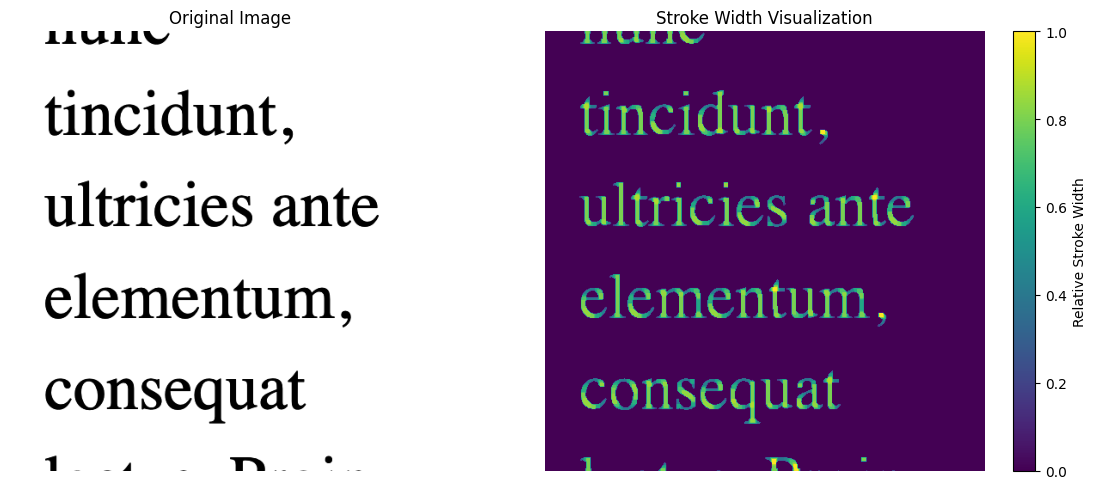

In [13]:
stroke_width_viz('serif-76px.png');

For the smaller `18px` font size, it's easier to to see which letters (l, t, N, D) have wider stroke widths. It's also showing some defects of this algorithm, as two different `D`s have different relative stroke widths.

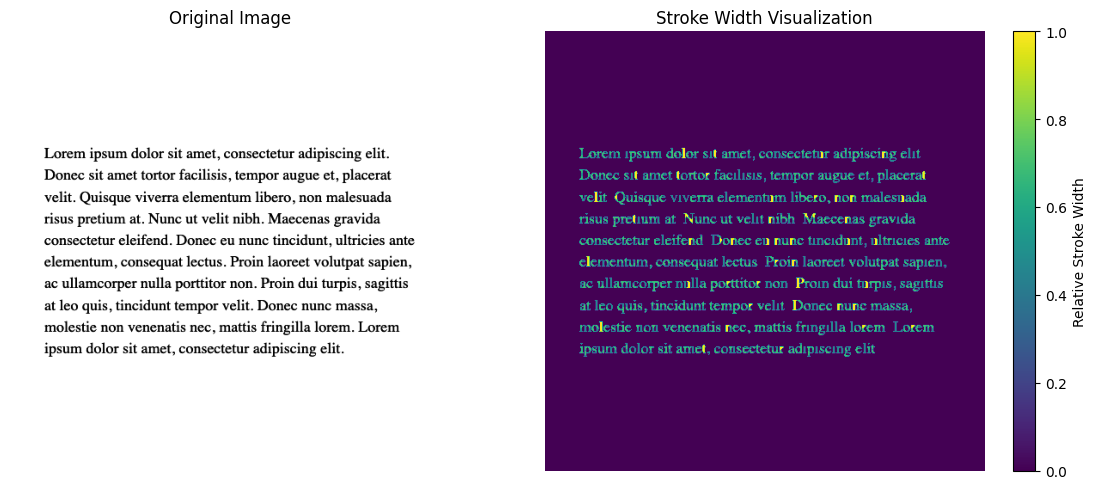

In [14]:
stroke_width_viz('serif-18px.png');

It's unclear from visual inspection how accurate this algorithm is for tiny font sizes (`8px`). I'm assuming it's not.

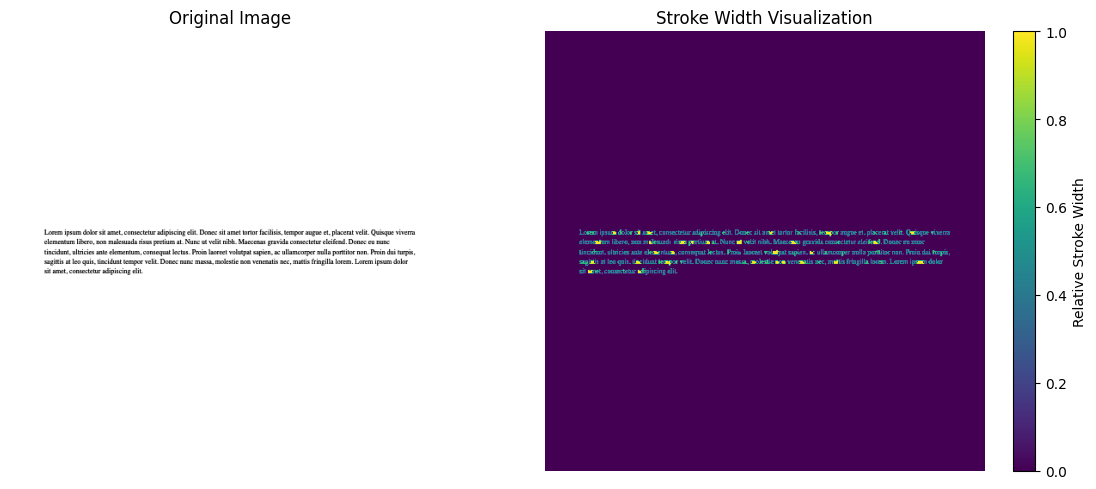

In [15]:
stroke_width_viz('serif-8px.png');

For a very large font size (`420px`) the dilation of the skeleton does not seem to be enough:

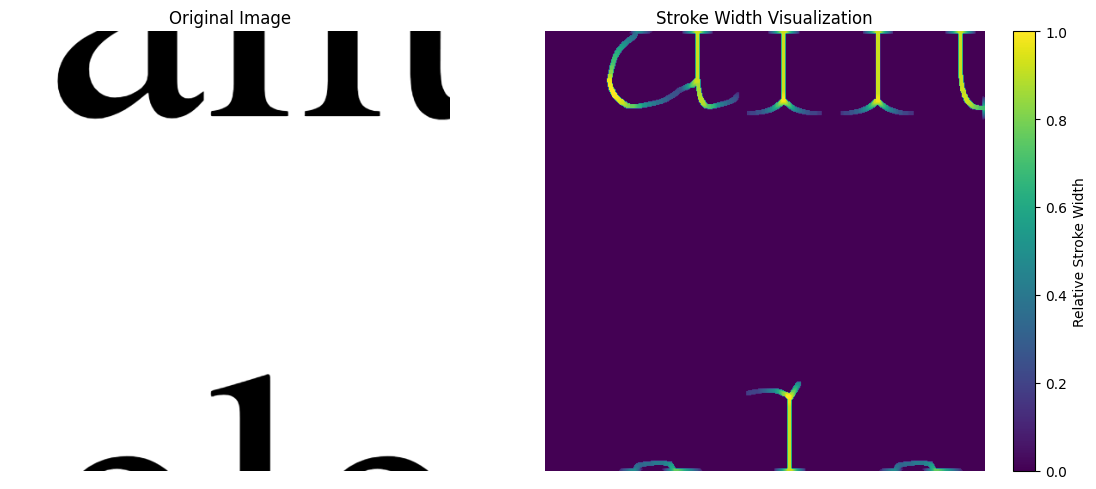

In [16]:
stroke_width_viz('serif-420px.png');

## Improving the Algorithm

The algorithm performs well for medium to large font sizes (36px, 76px). However, small font sizes show noisy, clumped areas of high stroke width, while for very large sizes, insufficient dilation leads to underestimating stroke width. I think the issue is the kernel size during dilation. I'll incorporate (with Claude's help) a modified kernel size based on the average letter height (calculated with a bounding rectangle for each letter).

In [17]:
#| code-fold: true
#| code-summary: "Show updated `stroke_width_viz` code"

def stroke_width_viz(path):
    # Read the image
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # Threshold the image
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Calculate average height of bounding rectangles
    heights = [cv2.boundingRect(contour)[3] for contour in contours]
    avg_height = np.median(heights)

    # Determine kernel size based on average height
    #kernel_size = max(3, int(avg_height / 6))
    kernel_size = 2 if int(avg_height / 5) == 0 else max(3, int(avg_height / 5))
    print(kernel_size)

    # Create a skeleton of the image
    skeleton = cv2.ximgproc.thinning(binary)

    # Compute distance transform
    dist_transform = cv2.distanceTransform(binary, cv2.DIST_L2, 5)

    # Initialize stroke width map
    stroke_width_map = np.zeros_like(dist_transform)

    # Find non-zero pixels in the skeleton
    y, x = np.where(skeleton > 0)

    # For each skeleton pixel, find the corresponding stroke width
    for i, j in zip(y, x):
        stroke_width = dist_transform[i, j] * 2  # Diameter is twice the radius
        stroke_width_map[i, j] = stroke_width

    # Dilate the stroke width map to fill the strokes
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    stroke_width_map = cv2.dilate(stroke_width_map, kernel, iterations=2)

    # Mask the stroke width map with the binary image
    stroke_width_map = stroke_width_map * (binary > 0)

    # Normalize the stroke width map for visualization
    stroke_width_map_norm = cv2.normalize(stroke_width_map, None, 0, 1, cv2.NORM_MINMAX)

    # Apply a color map
    stroke_width_color = cv2.applyColorMap((stroke_width_map_norm * 255).astype(np.uint8), cv2.COLORMAP_JET)

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Display the original image
    ax1.imshow(img, cmap='gray')
    ax1.set_title('Original Image')
    ax1.axis('off')

    # Display the colorized stroke width map
    ax2.imshow(cv2.cvtColor(stroke_width_color, cv2.COLOR_BGR2RGB))
    ax2.set_title('Stroke Width Visualization')
    ax2.axis('off')

    # Add a colorbar
    plt.colorbar(ax2.imshow(stroke_width_map_norm), ax=ax2, label='Relative Stroke Width')

    plt.tight_layout()
    plt.show()

    return stroke_width_map

19


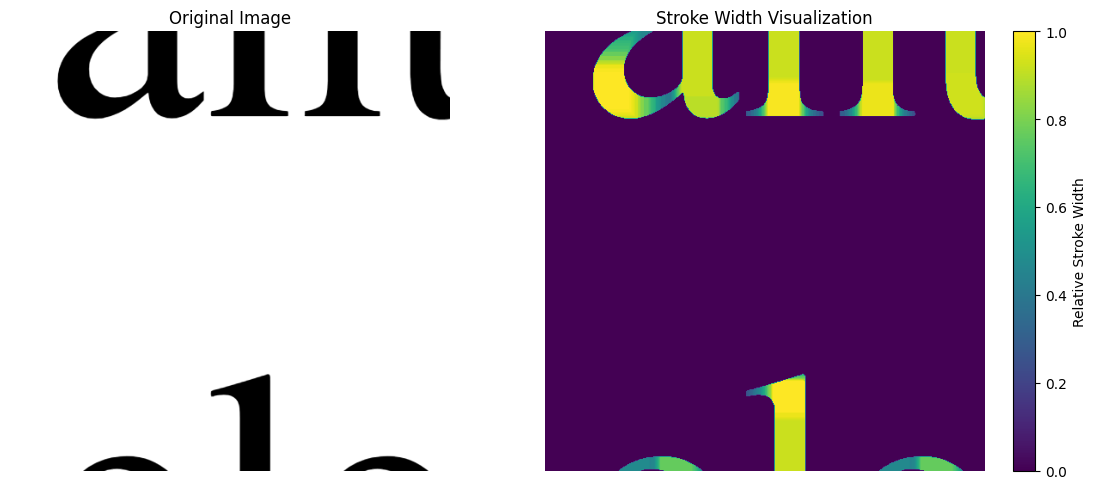

In [18]:
stroke_width_viz('serif-420px.png');

2


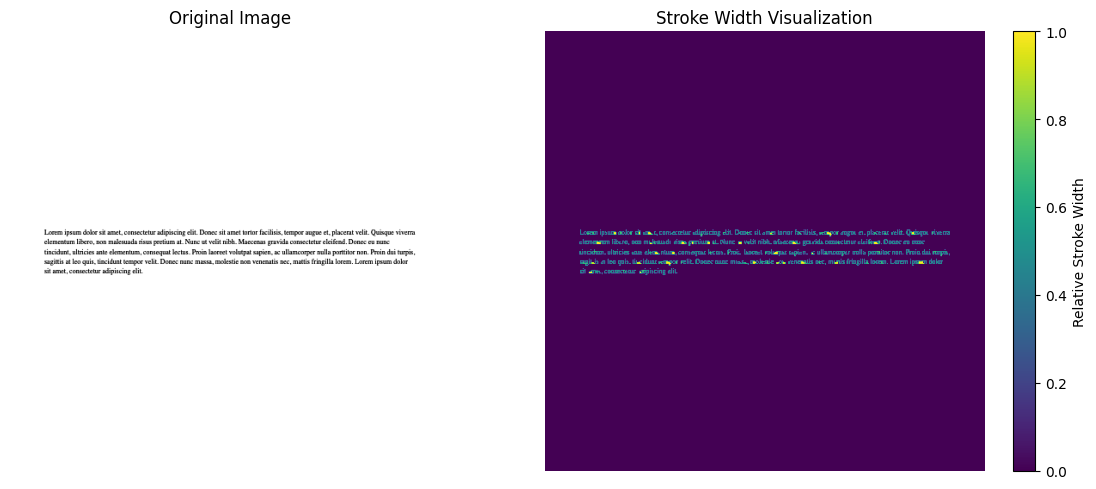

In [19]:
stroke_width_viz('serif-8px.png');

3


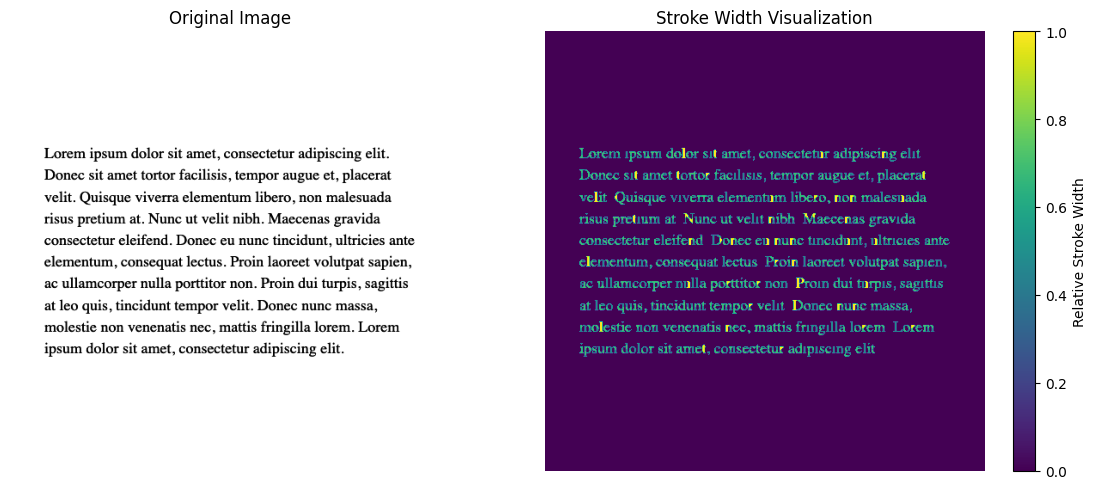

In [20]:
stroke_width_viz('serif-18px.png');

3


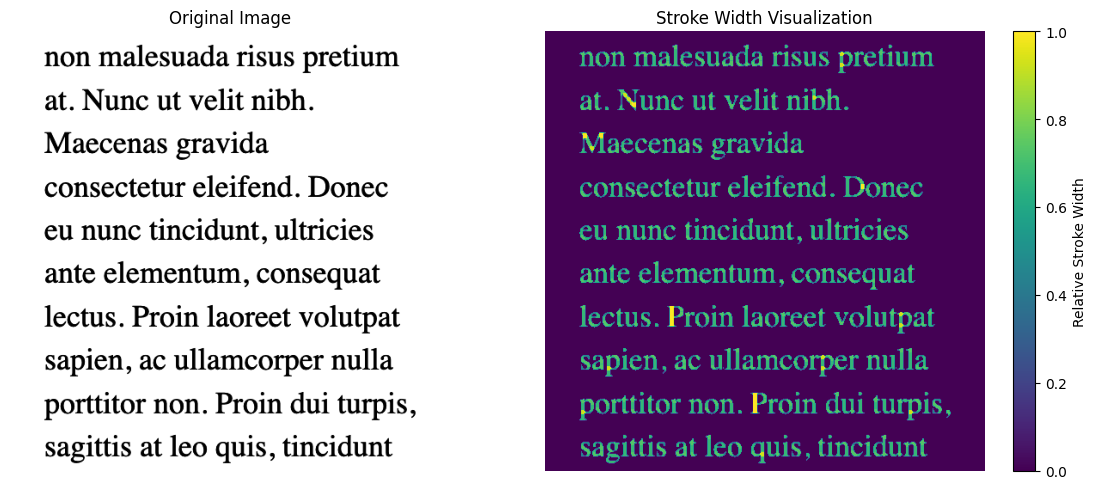

In [21]:
stroke_width_viz('serif-36px.png');

7


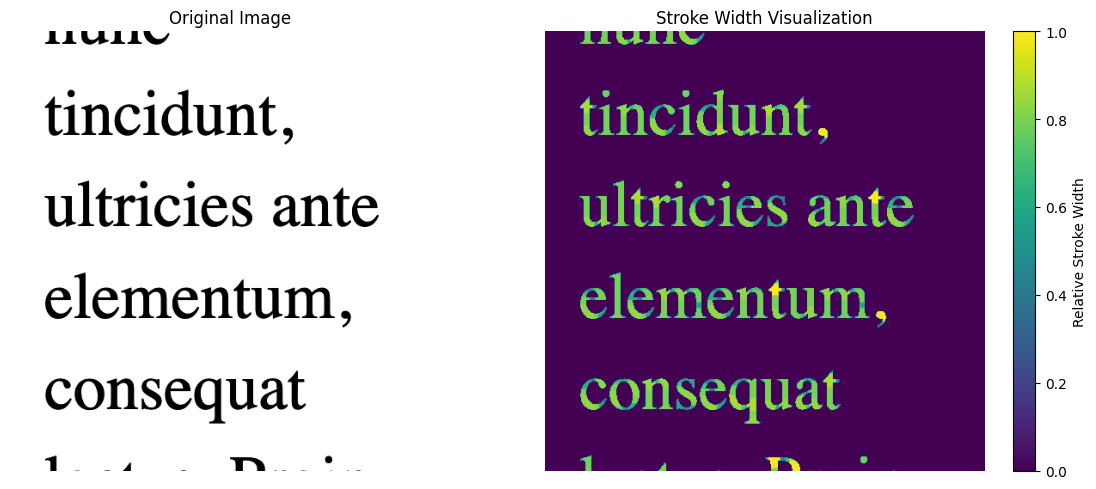

In [22]:
stroke_width_viz('serif-76px.png');

The updated algorithm performs better for very large font sizes.

## Calculating (Size Invariant) Average Stroke Width

By visual inspection, the algorithm seems to be accurately calculating the stroke width of the letters. To quantify its performance, I'll calculate an average stroke width for each image, which should remain consistent across different font sizes of the same font.

In [38]:
#| code-fold: true
#| code-summary: "Show `calculate_stroke_width` code"

def calculate_stroke_width(image_path):
    # Read the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Threshold the image
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Calculate average height of bounding rectangles
    heights = [cv2.boundingRect(contour)[3] for contour in contours]
    avg_height = np.median(heights)

    # Create a skeleton of the image
    skeleton = cv2.ximgproc.thinning(binary)

    # Compute distance transform
    dist_transform = cv2.distanceTransform(binary, cv2.DIST_L2, 5)

    # Initialize stroke width map
    stroke_width_map = np.zeros_like(dist_transform)

    # Find non-zero pixels in the skeleton
    y, x = np.where(skeleton > 0)

    # For each skeleton pixel, find the corresponding stroke width
    for i, j in zip(y, x):
        stroke_width = dist_transform[i, j] * 2  # Diameter is twice the radius
        stroke_width_map[i, j] = stroke_width

    # Determine kernel size based on average height
    kernel_size = 2 if int(avg_height / 5) == 0 else max(3, int(avg_height / 5))

    # Dilate the stroke width map to fill the strokes
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    stroke_width_map = cv2.dilate(stroke_width_map, kernel, iterations=2)

    # Mask the stroke width map with the binary image
    stroke_width_map = stroke_width_map * (binary > 0)

    # Calculate the average stroke width for normalized non-zero stroke widths
    non_zero_stroke_widths = stroke_width_map[stroke_width_map != 0]
    normalized_stroke_widths = non_zero_stroke_widths / np.max(non_zero_stroke_widths)
    avg_stroke_width = np.median(normalized_stroke_widths)

    return avg_stroke_width

There still exists variance in average stroke width across font size within the same typeface, but overall, for font sizes between 18 and 76px, the median stroke width for `display` is larger than `serif` which intuitively makes sense because the `display` font visually has thicker strokes.

In [40]:
#| code-fold: true
#| code-summary: "Show stroke width calculation for-loop"

font_szs = [18, 24, 36, 76]
sws = []
typefaces = ["display", "serif"]

for t in typefaces:
  for sz in font_szs:
    sws.append(calculate_stroke_width(f"{t}-{sz}px.png"))

df = pd.DataFrame({
    'typeface': ["display"]*len(font_szs) + ["serif"]* len(font_szs),
    'font-sizes': font_szs*2,
    'median stroke-width': sws})

df

,typeface,font-sizes,median stroke-width
0,display,18,0.714286
1,display,24,0.666667
2,display,36,0.750000
3,display,76,0.781629
4,serif,18,0.700000
5,serif,24,0.637262
6,serif,36,0.666667
7,serif,76,0.800000


In [42]:
df.groupby('typeface')['median stroke-width'].agg(['median', 'mean'])

,median,mean
typeface,,
display,0.732143,0.728145
serif,0.683333,0.700982


8


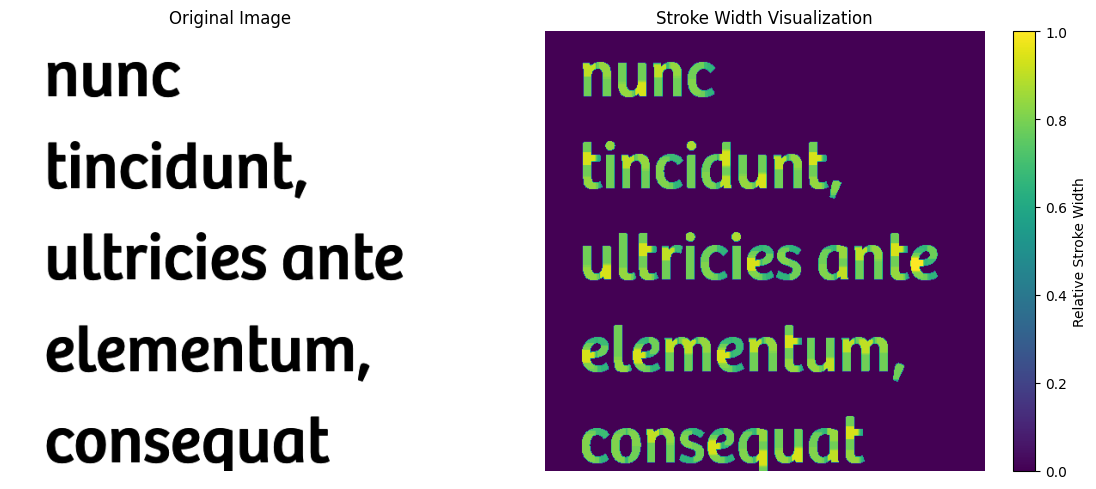

In [43]:
stroke_width_viz('display-76px.png');

7


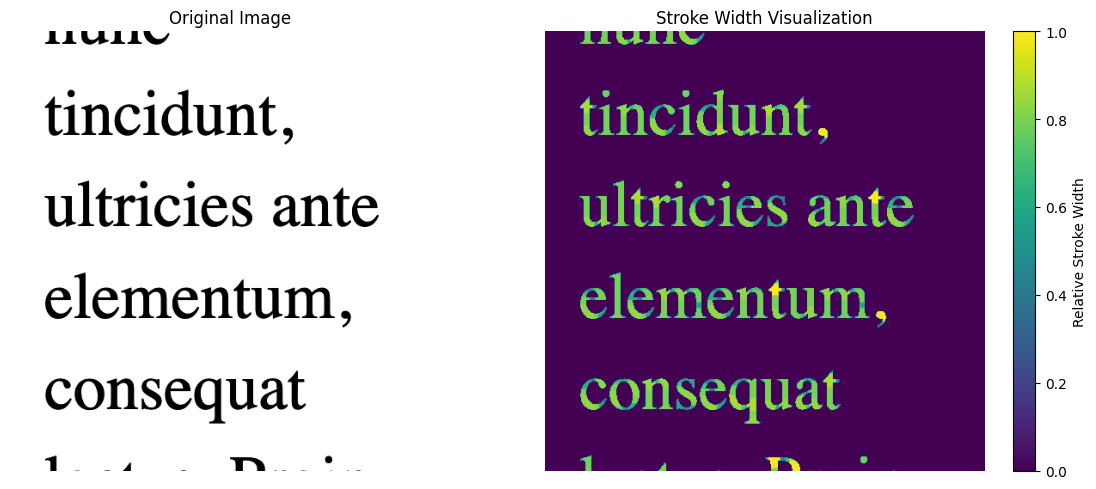

In [44]:
stroke_width_viz('serif-76px.png');

## Final Thoughts

I enjoyed iterating this algorithm with Claude. In this non-ML baseline development process, I prioritize simpler code over higher accuracy. For average stroke width, I restricted input font sizes to 18-76px, excluding very small (8px) and very large (420px) sizes, to achieve a final metric that distinguishes typefaces in a way that matches my intuition.

While observing the stroke width heat maps, I noticed that each letter's bounding rectangle has varying amounts of negative (black) and positive (white) space, depending on the typeface. I plan to explore this next!

I hope you enjoyed this blog post! Follow me on Twitter [@vishal_learner](https://twitter.com/vishal_learner).